In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import spacy
import tensorflow as tf

from tensorflow import keras
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
embedding_dim = 200
maxlen = 64
clear_embedding_matrix = False

In [3]:
def recall_metric(y_true, y_pred):	
    """Recall metric.	
     Only computes a batch-wise average of recall.	
     Computes the recall, a metric for multi-label classification of	
    how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

In [4]:
def save_model(model, model_path="data/models/MSA_cnn_model.json", weights_path="data/models/MSA_cnn_model.hdf"):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weights_path)
    print("Saved model to data/models/MSA_cnn_model.json")

In [5]:
with open("models/tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)
print("loaded tokenizer from models/tokenizer.pickle")
vocab_size = len(tokenizer.word_index) + 1

loaded tokenizer from models/tokenizer.pickle


In [6]:
if os.path.exists("models/embedding_matrix.pickle") and not clear_embedding_matrix:
    with open("models/embedding_matrix.pickle", "rb") as handle:
        embedding_matrix = pickle.load(handle)
    print("loaded embedding_matrix from models/embedding_matrix.pickle")
else:
    print("models/embedding_matrix.pickle not found; creating a new embedding_matrix")
    vocab_size = len(tokenizer.word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(glove_filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in tokenizer.word_index:
                idx = tokenizer.word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    # save for the future
    with open("models/embedding_matrix.pickle", "wb") as handle:
        pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("saving embedding_matrix to models/embedding_matrix.pickle")

loaded embedding_matrix from models/embedding_matrix.pickle


In [157]:
training_df = pd.read_csv('data/training_data/moral_training_set.csv')
training_df.head()

,text,moral_saliency,moral_intrinsicality,notes
0,All human beings have inherent worth.,1,3,NaN
1,It's wrong to exploit people you have power over.,1,2,NaN
2,Jeff Bezos is an evil man.,1,1,NaN
3,Human beings have a brain that resides in thei...,0,0,NaN
4,It's incorrect to assume that one plus one is ...,0,0,NaN


In [8]:
train = training_df.sample(frac=0.666)
test = training_df.drop(train.index)
print("train len: ", len(train))
print("test len: ", len(test))

train len:  100
test len:  50


In [9]:
input_train = tokenizer.texts_to_sequences(train["text"].values)
input_test = tokenizer.texts_to_sequences(test["text"].values)

In [10]:
input_train = pad_sequences(input_train, padding='post', maxlen=maxlen)
input_test = pad_sequences(input_test, padding='post', maxlen=maxlen)

In [11]:
output_train = train["moral_saliency"]
output_test = test["moral_saliency"]

In [12]:
def plot_training(history):
    acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    plt.style.use("ggplot")
    plt.plot(acc, color=(0.1, 0.2, 0.6, 0.6), label="train acc", lw=3)
    plt.plot(val_acc, color=(0.1, 0.6, 0.2, 0.6), label="validation acc", lw=3)
    plt.suptitle("MSA Training Accuracy\n\n", fontsize=16, y=1.05)
    plt.legend()
    plt.show()
    recall = history.history["recall_metric"]
    val_recall = history.history["val_recall_metric"]
    plt.style.use("ggplot")
    plt.plot(recall, color=(0.1, 0.2, 0.6, 0.6), label="train recall", lw=3)
    plt.plot(val_recall, color=(0.1, 0.6, 0.2, 0.6), label="validation recall", lw=3)
    plt.suptitle("MSA Training Recall\n\n", fontsize=16, y=1.05)
    plt.legend()
    plt.show()

## A Very Simple Model

In [13]:
# Create a new model
def new_max_pool():
    max_pool = keras.Sequential()
    max_pool.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=False))
    max_pool.add(keras.layers.GlobalMaxPool1D())
    max_pool.add(keras.layers.Dropout(0.2))
    max_pool.add(keras.layers.Dense(1, activation='sigmoid'))
    max_pool.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=["accuracy", recall_metric])
    return max_pool

# A Model with 1 Convolutional Layer

In [14]:
# Create a new model
def new_conv_max_pool():
    one_conv_layer_model = keras.Sequential()
    one_conv_layer_model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=False))
    one_conv_layer_model.add(keras.layers.Dropout(0.2))
    one_conv_layer_model.add(keras.layers.Conv1D(filters=32, kernel_size=4))
    one_conv_layer_model.add(keras.layers.Dropout(0.2))
    one_conv_layer_model.add(keras.layers.GlobalMaxPool1D())
    one_conv_layer_model.add(keras.layers.Dropout(0.2))
    one_conv_layer_model.add(keras.layers.Dense(1, activation='sigmoid'))
    one_conv_layer_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=["accuracy", recall_metric])
    return one_conv_layer_model

# 1 Conv and 1 Dense Layer

In [15]:
# Create a new model
def new_conv_max_pool_dense():
    conv_dense_model = keras.Sequential()
    conv_dense_model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=False))
    conv_dense_model.add(keras.layers.Dropout(0.3))
    conv_dense_model.add(keras.layers.Conv1D(filters=32, kernel_size=4))
    conv_dense_model.add(keras.layers.Dropout(0.3))
    conv_dense_model.add(keras.layers.GlobalMaxPool1D())
    conv_dense_model.add(keras.layers.Dropout(0.3))
    conv_dense_model.add(keras.layers.Dense(32, activation='relu'))
    conv_dense_model.add(keras.layers.Dropout(0.3))
    conv_dense_model.add(keras.layers.Dense(1, activation='sigmoid'))
    conv_dense_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=["accuracy", recall_metric])
    return conv_dense_model


# K-Fold Cross Validation

In [67]:
def get_new_split(frac=0.666):
    train = training_df.sample(frac=frac)
    test = training_df.drop(train.index)
    
    print(train["moral_saliency"].value_counts())
    print(test["moral_saliency"].value_counts())
    
    train_input = tokenizer.texts_to_sequences(train["text"].values)
    test_input = tokenizer.texts_to_sequences(test["text"].values)
    
    train_input = pad_sequences(train_input, padding='post', maxlen=maxlen)
    test_input = pad_sequences(test_input, padding='post', maxlen=maxlen)
    
    train_output = train["moral_saliency"]
    test_output = test["moral_saliency"]
    
    return train_input, train_output, test_input, test_output

In [90]:
def get_new_equal_split(frac=0.666):
    positive_df = training_df[training_df["moral_saliency"] == 1]
    negative_df = training_df[training_df["moral_saliency"] == 0]
    positive_train = positive_df.sample(frac=frac)
    positive_test = positive_df.drop(positive_train.index)
    negative_train = negative_df.sample(frac=frac)
    negative_test = negative_df.drop(negative_train.index)
    train = pd.concat([positive_train, negative_train]).sample(frac=1)
    test = pd.concat([positive_test, negative_test]).sample(frac=1)
    
    train_input = tokenizer.texts_to_sequences(train["text"].values)
    test_input = tokenizer.texts_to_sequences(test["text"].values)
    
    train_input = pad_sequences(train_input, padding='post', maxlen=maxlen)
    test_input = pad_sequences(test_input, padding='post', maxlen=maxlen)
    
    train_output = train["moral_saliency"]
    test_output = test["moral_saliency"]
    
    return train_input, train_output, test_input, test_output

In [88]:
def model_train_test(model, train_input, train_output, validation_input, validation_output):
    history = model.fit(train_input, train_output,
                        epochs=12,
                        verbose=0,
                        validation_data=(validation_input, validation_output),
                        batch_size=16,
                        class_weight={1: 5, 0: 1})
    return history.history

In [53]:
validation_split=0.33
k = 10

max_pool_results = {"val_acc": [], "val_recall": []}
conv_max_pool_results = {"val_acc": [], "val_recall": []}
conv_max_pool_dense_results = {"val_acc": [], "val_recall": []}

for i in range(5):
    print("Round ", i, end=" ")
    train_input, train_output, test_input, test_output = get_new_split()
    max_pool_model = new_max_pool()
    history = model_train_test(max_pool_model, train_input, train_output, test_input, test_output)
    max_pool_results["val_acc"].append(history["val_acc"])
    max_pool_results["val_recall"].append(history["val_recall_metric"])
    print("#", end="")
    
    conv_max_pool_model = new_conv_max_pool()
    history = model_train_test(conv_max_pool_model, train_input, train_output, test_input, test_output)
    conv_max_pool_results["val_acc"].append(history["val_acc"])
    conv_max_pool_results["val_recall"].append(history["val_recall_metric"])
    print("#", end="")
    
    conv_max_pool_dense_model = new_conv_max_pool_dense()
    history = model_train_test(conv_max_pool_dense_model, train_input, train_output, test_input, test_output)
    conv_max_pool_dense_results["val_acc"].append(history["val_acc"])
    conv_max_pool_dense_results["val_recall"].append(history["val_recall_metric"])
    print("#", end="")
    print()

Round  0 ###Round  1 ###Round  2 ###Round  3 ###Round  4 ###

In [54]:
for results in [max_pool_results, conv_max_pool_results, conv_max_pool_dense_results]:
    for key in results:
        print("{}: {}".format(key, np.mean(results[key])))

val_acc: 0.36866666666666675
val_recall: 0.7192931154568991
val_acc: 0.6880000000000001
val_recall: 0.7075047556559243
val_acc: 0.47900000000000004
val_recall: 0.7253417923450469


In [71]:
final_recall = []
final_acc = []

0    67
1    38
Name: moral_saliency, dtype: int64
0    33
1    19
Name: moral_saliency, dtype: int64


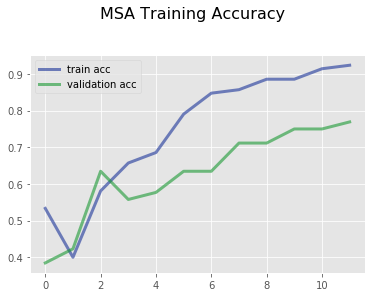

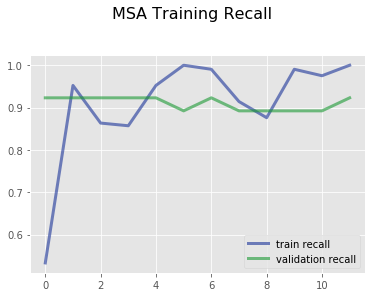

In [84]:
model = new_conv_max_pool()
train_input, train_output, test_input, test_output = get_new_equal_split(frac=0.666)
history = model.fit(train_input, train_output,
                    epochs=12,
                    verbose=0,
                    validation_data=(test_input, test_output),
                    batch_size=8,
                    class_weight={1: 6, 0: 1})
plot_training(history)
final_recall.append(history.history["val_recall_metric"][-1])
final_acc.append(history.history["val_acc"][-1])
for index, row in training_df.iterrows():
    text_sequence = tokenizer.texts_to_sequences([row["text"]])
    padded_text_sequence = pad_sequences(text_sequence, padding='post', maxlen=maxlen)
    result = model.predict(padded_text_sequence)
    if np.round(result) != row["moral_saliency"] and row["moral_saliency"] == 1:
            print(row["text"])

In [85]:
print(len(final_recall))
print(np.mean(final_recall))
print(np.mean(final_acc))

7
0.9377289237556877
0.8003663016762925


# Exploring Effect of Convolutional Window on Accuracy, Recall

In [127]:
def get_model(kernel_size=4, dropout=0.2):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=False))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=kernel_size))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.GlobalMaxPool1D())
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=["accuracy", recall_metric])
    return model

In [133]:
k = 2

kernel_sizes = [2, 4, 6, 8, 10]

results = {i: {"val_acc": [], "val_recall": []} for i in kernel_sizes}

train_input, train_output, test_input, test_output = get_new_equal_split(frac=0.5)

for i in range(k):
    print("Round ", i, end=" ")
    for kernel_size in kernel_sizes:
        print("#", end="")
        model = get_model(kernel_size=kernel_size, dropout=0.2)
        history = model_train_test(model, train_input, train_output, test_input, test_output)
        results[kernel_size]["val_acc"].append(history["val_acc"][-1])
        results[kernel_size]["val_recall"].append(history["val_recall_metric"][-1])
    print()

Round  0 #####
Round  1 #####


[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [233]:
average_recall = [np.mean(results[i]["val_recall"]) for i in kernel_sizes]
average_acc = [np.mean(results[i]["val_acc"]) for i in kernel_sizes]
plt.style.use("ggplot")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(4)
f.set_figwidth(12)

ax1.plot(kernel_sizes, average_recall, label="validation recall", lw=3)
ax1.set_ylabel("Validation Recall")
ax1.set_xlabel("Convolutional Kernel Size")

ax2.plot(kernel_sizes, average_acc, label="validation acc", lw=3)
ax2.set_ylabel("Validation Accuracy")
ax2.set_xlabel("Convolutional Kernel Size")

plt.suptitle("Validation Performance vs Convolutional Kernel Size\n\n", fontsize=16)
plt.show()

TypeError: 'int' object is not subscriptable

# Exploring Effect of Dropout on Accuracy, Recall

In [130]:
k = 2

dropout_levels = [0, 0.2, 0.4, 0.6, 0.8]

dropout_results = {i: {"val_acc": [], "val_recall": []} for i in dropout_levels}

train_input, train_output, test_input, test_output = get_new_equal_split(frac=0.5)

for i in range(k):
    print("Round ", i, end=" ")
    for dropout_level in dropout_levels:
        print("#", end="")
        model = get_model(dropout=dropout_level)
        history = model_train_test(model, train_input, train_output, test_input, test_output)
        dropout_results[dropout_level]["val_acc"].append(history["val_acc"][-1])
        dropout_results[dropout_level]["val_recall"].append(history["val_recall_metric"][-1])
    print()

Round  0 #####
Round  1 #####


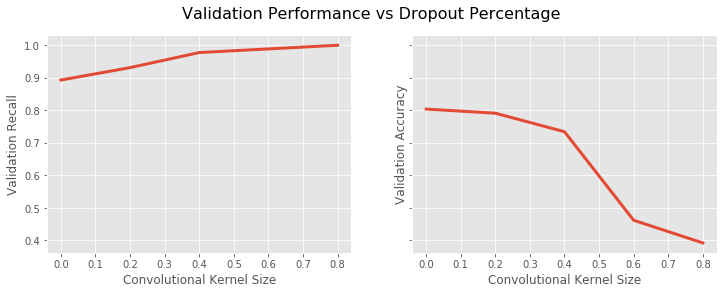

In [154]:
average_recall = [np.mean(dropout_results[i]["val_recall"]) for i in dropout_levels]
average_acc = [np.mean(dropout_results[i]["val_acc"]) for i in dropout_levels]
plt.style.use("ggplot")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(4)
f.set_figwidth(12)

ax1.plot(dropout_levels, average_recall, label="validation recall", lw=3)
ax1.set_ylabel("Validation Recall")
ax1.set_xlabel("Convolutional Kernel Size")

ax2.plot(dropout_levels, average_acc, label="validation acc", lw=3)
ax2.set_ylabel("Validation Accuracy")
ax2.set_xlabel("Convolutional Kernel Size")

plt.suptitle("Validation Performance vs Dropout Percentage\n\n", fontsize=16)
plt.show()

# Exploring Accuracy, Recall on Different Lengths


(array([33., 47., 45., 13., 10.]),
 array([ 5, 10, 15, 20, 25, 30]),
 <a list of 5 Patch objects>)

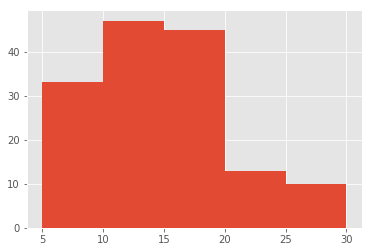

In [185]:
training_df["length"] = training_df["text"].apply(lambda x: len(x.split()))
plt.hist(training_df["length"], bins=[5, 10, 15, 20, 25, 30])

In [213]:
lengths = []
results = []

In [226]:
model = get_model()
train_input, train_output, test_input, test_output = get_new_equal_split(frac=0.8)
history = model.fit(train_input, train_output,
                    epochs=12,
                    verbose=1,
                    validation_data=(test_input, test_output),
                    batch_size=8,
                    class_weight={1: 6, 0: 1})

Train on 129 samples, validate on 32 samples
Epoch 1/12
129/129 [==============================] - 19s 148ms/step - loss: 0.8469 - acc: 0.4341 - recall_metric: 0.6646 - val_loss: 1.0073 - val_acc: 0.3750 - val_recall_metric: 1.0000
Epoch 2/12
129/129 [==============================] - 0s 2ms/step - loss: 0.5244 - acc: 0.5116 - recall_metric: 0.8630 - val_loss: 0.7362 - val_acc: 0.4375 - val_recall_metric: 0.9500
Epoch 3/12
129/129 [==============================] - 0s 2ms/step - loss: 0.4313 - acc: 0.5659 - recall_metric: 0.9483 - val_loss: 0.6855 - val_acc: 0.4688 - val_recall_metric: 0.9500
Epoch 4/12
129/129 [==============================] - 0s 2ms/step - loss: 0.3157 - acc: 0.6977 - recall_metric: 0.9457 - val_loss: 0.5531 - val_acc: 0.6875 - val_recall_metric: 0.9500
Epoch 5/12
129/129 [==============================] - 0s 2ms/step - loss: 0.2887 - acc: 0.8217 - recall_metric: 0.9922 - val_loss: 0.5667 - val_acc: 0.6250 - val_recall_metric: 0.9500
Epoch 6/12
129/129 [============

In [227]:
for x, y in zip(test_input, test_output):
    length = list(x).index(0)
    while length > 2:
        lengths.append(length)
        result = model.predict(np.array([x]))
        x[length - 1] = 0
        length -= 1
        if np.round(result) == y:
            results.append(1)
        else:
            results.append(0)

In [230]:
bins = {5: [], 10: [], 15: [], 20: []}
for r, l in zip(results, lengths):
    if l < 5:
        bins[5].append(r)
    if l < 10:
        bins[10].append(r)
    elif l < 15:
        bins[15].append(r)
    elif l < 20:
        bins[20].append(r)
    elif l >= 15:
        bins[20].append(r)
for k in bins:
    print(k, ": ", np.mean(bins[k]), len(bins[k]))

5 :  0.6455696202531646 158
10 :  0.7613365155131265 419
15 :  0.8106508875739645 169
20 :  0.9520958083832335 167


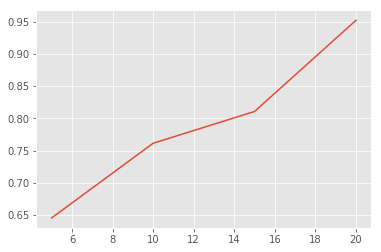

In [232]:
x = [5, 10 ,15, 20]
y = [np.mean(bins[xi]) for xi in x]
plt.plot(x, y)

In [64]:
test_set = pd.read_csv("data/training_data/moral_test_set.csv")
test_set.head()
count = 0
wrong = 0
count_pos = 0
wrong_pos = 0
for index, row in test_set.iterrows():
    count += 1
    text_sequence = tokenizer.texts_to_sequences([row["text"]])
    padded_text_sequence = pad_sequences(text_sequence, padding='post', maxlen=maxlen)
    result = model.predict(padded_text_sequence)
    if row["moral_saliency"] == 1:
        count_pos += 1
    if np.round(result) != row["moral_saliency"]:
        wrong += 1
        if row["moral_saliency"] == 1:
            wrong_pos += 1
        print(row)
print("\n\n")
print("Accuracy: ", (count - wrong) / count)
print("Recall: ", (count_pos - wrong_pos) / count_pos)

text                    The said truth is that it is the greatest happ...
moral_saliency                                                          1
moral_intrinsicality                                                    3
notes                   Consequentialism (utilitarianism); Jeremy Bent...
Name: 4, dtype: object
text                    I don't know what was going through Elizabeth ...
moral_saliency                                                          1
moral_intrinsicality                                                    1
notes                                             Long positive test case
Name: 13, dtype: object
text                    But does she really wanna But can't stand to s...
moral_saliency                                                          0
moral_intrinsicality                                                    0
notes                                             Long negative test case
Name: 15, dtype: object
text                    You should really

In [18]:
# Create a new model
msa_cnn_model = keras.Sequential()
msa_cnn_model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
msa_cnn_model.add(keras.layers.Conv1D(filters=32, kernel_size=4))
msa_cnn_model.add(keras.layers.GlobalMaxPool1D())
msa_cnn_model.add(keras.layers.Dense(32, activation='relu'))
msa_cnn_model.add(keras.layers.Dropout(0.5))
msa_cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))
msa_cnn_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=["accuracy", recall_metric])
msa_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 64, 200)           61876400  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 61, 32)            25632     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 61,903,121
Trainable params: 26,721
Non-trainable params: 61,876,400
___________________________________________________________

In [19]:
history = msa_cnn_model.fit(input_train, output_train,
                    epochs=12,
                    verbose=1,
                    validation_data=(input_test, output_test),
                    batch_size=8,
                    class_weight={1: 10, 0: 1})
loss, accuracy, recall = msa_cnn_model.evaluate(input_test, output_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Recall:  {:.4f}".format(recall))

Train on 100 samples, validate on 50 samples
Epoch 1/16
100/100 [==============================] - 1s 12ms/step - loss: 0.5957 - acc: 0.3600 - recall_metric: 0.9800 - val_loss: 1.1525 - val_acc: 0.3400 - val_recall_metric: 0.6400
Epoch 2/16
100/100 [==============================] - 0s 773us/step - loss: 0.5248 - acc: 0.3800 - recall_metric: 1.0000 - val_loss: 0.9513 - val_acc: 0.3400 - val_recall_metric: 0.6400
Epoch 3/16
100/100 [==============================] - 0s 749us/step - loss: 0.4713 - acc: 0.4100 - recall_metric: 0.8800 - val_loss: 0.8668 - val_acc: 0.3600 - val_recall_metric: 0.6400
Epoch 4/16
100/100 [==============================] - 0s 735us/step - loss: 0.4154 - acc: 0.5000 - recall_metric: 0.8400 - val_loss: 0.7327 - val_acc: 0.4400 - val_recall_metric: 0.6400
Epoch 5/16
100/100 [==============================] - 0s 706us/step - loss: 0.3594 - acc: 0.6300 - recall_metric: 0.9040 - val_loss: 0.6358 - val_acc: 0.5600 - val_recall_metric: 0.6000
Epoch 6/16
100/100 [======

In [17]:
save_model(msa_cnn_model, model_path="data/models/msa_model.json", weights_path="data/models/msa_weights.hdf")


Consider using a TensorFlow optimizer from `tf.train`.
Saved model to data/models/MSA_cnn_model.json


In [51]:
test_set = pd.read_csv("data/training_data/moral_test_set.csv")
test_set.head()

,text,moral_saliency,moral_intrinsicality,notes
0,The most ethical course of action is the one t...,1,3,Consequentialism (utilitarianism); colloquial
1,Results of actions don't matter as much as the...,1,3,Deontology; colloquial
2,Morality is about becoming the right kind of p...,1,3,Virtue Ethics; colloquial
3,Act only according to that maxim whereby you c...,1,3,"Deontology; Immanuel Kant, Groundwork of Metap..."
4,The said truth is that it is the greatest happ...,1,3,Consequentialism (utilitarianism); Jeremy Bent...


In [53]:
count = 0
wrong = 0
count_pos = 0
wrong_pos = 0
for index, row in test_set.iterrows():
    count += 1
    text_sequence = tokenizer.texts_to_sequences([row["text"]])
    padded_text_sequence = pad_sequences(text_sequence, padding='post', maxlen=maxlen)
    result = msa_cnn_model.predict(padded_text_sequence)
    if row["moral_saliency"] == 1:
        count_pos += 1
    if np.round(result) != row["moral_saliency"]:
        wrong += 1
        if row["moral_saliency"] == 1:
            wrong_pos += 1
        print(row)
print("\n\n")
print("Accuracy: ", (count - wrong) / count)
print("Recall: ", (count_pos - wrong_pos) / count_pos)

text                    The most ethical course of action is the one t...
moral_saliency                                                          1
moral_intrinsicality                                                    3
notes                       Consequentialism (utilitarianism); colloquial
Name: 0, dtype: object
text                    Results of actions don't matter as much as the...
moral_saliency                                                          1
moral_intrinsicality                                                    3
notes                                              Deontology; colloquial
Name: 1, dtype: object
text                    Morality is about becoming the right kind of p...
moral_saliency                                                          1
moral_intrinsicality                                                    3
notes                                           Virtue Ethics; colloquial
Name: 2, dtype: object
text                    Act only according 

In [27]:
text = "profit is more important than equality"
text_sequence = tokenizer.texts_to_sequences([text])
padded_text_sequence = pad_sequences(text_sequence, padding='post', maxlen=maxlen)
result = msa_cnn_model.predict(padded_text_sequence)
print(type(result))
print(type(result[0]))
print(type(result[0][0]))
print(result)
if result[0][0] > 0.5:
    print("MORAL")
else:
    print("NOT MORAL")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float32'>
[[0.8681602]]
MORAL


In [30]:
model = msa_cnn_model
def train_single(text, label):
    maxlen = 64
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=["accuracy"])
    text_sequence = tokenizer.texts_to_sequences([text])
    padded_text_sequence = pad_sequences(text_sequence, padding='post', maxlen=maxlen)
    model.fit(padded_text_sequence, np.array([[float(label)]]),
                    epochs=1,
                    verbose=0,
                    batch_size=1,
                    class_weight={1: 10, 0: 1})

train_single("I think you should go to hell", 0)

In [ ]:
save_model(model)